# Tight-Binding Model in One Dimension: Using fermions.jl

This notebook demonstrates the typical kind of calculations that are possible using the fermions.jl library. The model considered here is a prototypical one, involving spinless electrons hopping on a 1D lattice, with open boundary conditions (the electrons cannot hop beyond the left and right edges of the chain).

<img style="width: 750px" src="tbm1D.png"/>

The Hamiltonian of the model is very simple; there are only two kinds of processes - one that starts from a lattice site $i$ and goes to the site next to it ($i+1$), and another one that goes to the site before it ($i-1$). In terms of operators, the Hamiltonian can be written as
$$
H = \sum_i \left(c^\dagger_i c_{i+1} + c^\dagger_{i+1}c_i\right)~.
$$

In this notebook, we will now show how to accomplish the following:

- define the above Hamiltonian
- diagonalise this Hamiltonian
- calculate the gap in the low-energy spectrum, and show that the gap vanishes in the thermodynamic limit
- calculate the distribution of particles on the lattice in the ground state
- calculate the local particle density as a function of temperature
- calculate the entanglement of a region of space
- calculate the spectral function. 

## Importing Packages

In [1]:
using fermions # Importing fermions.jl library
using Plots, Measures # Importing tools for plotting
Plots.theme(:dark)

## Defining a Set of Basis States

Most applications of this libray require us to define a choice of basis states. The most convenient basis for us is the real space basis, consisting of states such `[1, 0, 1, 1, ..., 0, 1]`, where each number in the vector can be 0 or 1, and the $i^\mathrm{th}$ number represents whether the $i^\mathrm{th}$ lattice site is occupied(`1`) or unoccupied(`0`). Within the library, we define the basis states using the function BasisStates:
```
basis = fermions.BasisStates(numSites, occupancy)
```
Here, the first argument `numSites` is an `Int` that represents the number of lattice sites that must be taken into account while creating the basis, while the second (optional) argument `occupancy` is another `Int` which represents the number of occupied particles in the basis states. For example, if we choose `basis = fermions.BasisStates(2, 1)`, that will return the basis states involving two lattice sites and one electron occupying those sites, leading to the basis `[1, 0], [0, 1]`.

## Creating the Hamiltonian

Any general second-quantised Hamiltonian can be represented, while using the library, as a 1D array. In order to explain how to create the Hamiltonian, we will start by giving a very simple example. The (non-Hermitian) Hamiltonian $c^\dagger_1 c_2 - c^\dagger_3 c_4$ is represented as
```
H = [
        ("+-", [1, 2], 1.0),
        ("+-", [3, 4], -1.0),
    ]
```
Each tuple `(...)` within the array represents a term of the full Hamiltonian. The term $c^\dagger_1 c_2$ is represented by the first tuple `("+-", [1, 2], 1.0)`; the string `"+-"` encodes the fact that the operator is a product of a creation operator(`+`) and an annihilation operator(`-`), the vector `[1,2]` indicates that the `+` and `-` operators act on the first and second indices within in each basis states, and the third (`Float`) `1.0` indicates the strength of this term. 

The second tuple `("+-", [3, 4], -1.0)` can be understood as a representation of the second operator $- c^\dagger_3 c_4$ in the same way.

In [2]:
# designing the tight-binding Hamiltonian
function TightBindHamiltonian(numSites)

    # define the array of tuples to store all terms in the Hamiltonian 
    hamiltonianTerms = Tuple{String, Vector{Int64}, Float64}[]

    # loop over all lattice sites (skip the end, because we have c^\dagger_i+1 
    for i in 1:numSites-1

        # the term c^\dagger_i c_i+1
        term1 = ("+-", [i, i+1], 1.0)

        # the term c^\dagger_i+1 c_i
        term2 = ("+-", [i+1, i], 1.0)

        # add both terms to the Hamiltonian
        push!(hamiltonianTerms, term1)
        push!(hamiltonianTerms, term2)
    end
    return hamiltonianTerms
end

TightBindHamiltonian (generic function with 1 method)

## Spectral Gap

As a concrete demonstration, we will now design and diagonalise this Hamiltonian for multiple values of `numSites` (the number of lattice sites), and show that as the number of lattice sites is increased, the gap between the ground state and the lowest excited state tends to zero. The physical import of this is that in the thermodynamic limit ($\mathrm{numSites} \to \infty$), the spectrum becomes gapless.

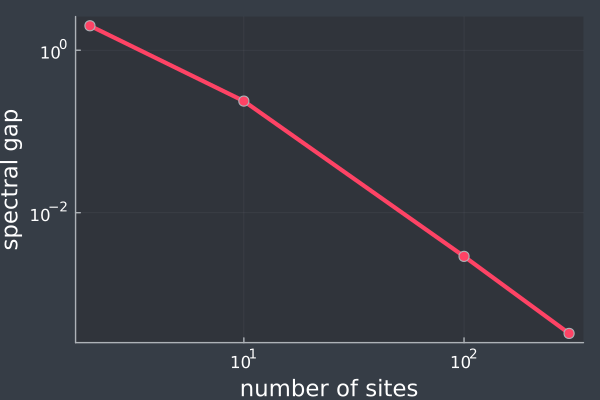

In [4]:
# array to store the spectral gap values (for multiple numSites)
gapResults = []

# range of numSites being considered
numSitesArray = [2, 10, 100, 300]
for numSites in numSitesArray

    # get basis and Hamiltonian
    basis = fermions.BasisStates(numSites, 1)
    hamiltonian = TightBindHamiltonian(numSites)

    # diagonalise the Hamiltonian to get eigenvalues and eigenvectors.
    # this is done using the library function fermions.Spectrum() which
    # is a thin wrapper around the julia LinearAlgebra function eigen(). 
    eigvals, eigvecs = fermions.Spectrum(hamiltonian, basis)

    # calculate and store the spectral gap
    spectralGap = eigvals[2] - eigvals[1]
    push!(gapResults, spectralGap)
end

Plots.plot(numSitesArray, gapResults; xlabel="number of sites", ylabel="spectral gap", markershape=:circle, 
    xscale=:log10, yscale=:log10, thickness_scaling=1.4, linewidth=3, legend=false, leftmargin=-5mm, bottommargin=-3mm)

## Local probability distribution

As another physically-motivated demonstration, we will calculate the real-space distribution of the ground state function, which amounts to calculating how likely it is to find the electron at a particular point in space. 

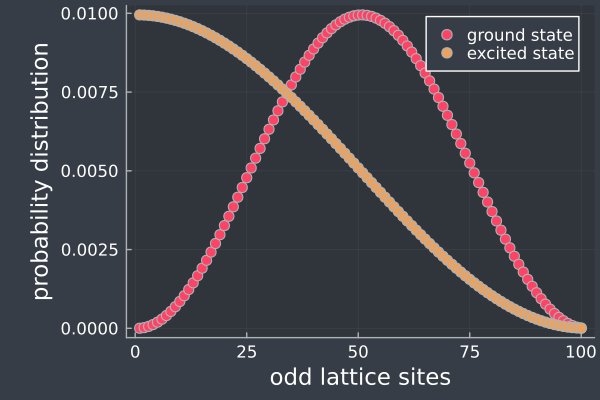

In [5]:
# get basis, Hamiltonian and eigenvectors.
numSites = 200
basis = fermions.BasisStates(numSites, 1)
hamiltonian = TightBindHamiltonian(numSites)
eigvals, eigvecs = fermions.Spectrum(hamiltonian, basis)

# Define the local density operator, which is just the number operator n_i at a site i. 
# Within the fermions.jl library, the number operator is represented using "n", just as c
# and c^† are represented using "-" and "+".
densityOperators = [[("n", [i], 1.0)] for i in 1:2:numSites]

# calculate the expectation value of the local density operator in the ground state 
# and a mid-spectrum state. the expectation value is calculated using an internal 
# function GenCorrelation(state, operator), which returns the quantity <state|operator|state>.
distribution_low = [fermions.GenCorrelation(eigvecs[1], operator) for operator in densityOperators]
distribution_mid = [fermions.GenCorrelation(eigvecs[div(numSites, 2)], operator) for operator in densityOperators]

Plots.scatter([distribution_low, distribution_mid], thickness_scaling=1.4, linewidth=3, legend=true,
        xlabel="odd lattice sites", ylabel="probability distribution", labels=["ground state" "excited state"], margin=-1mm)

## Real-space Entanglement Entropy

Measures of entanglement quantify how much a subsystem is correlated with other regions of space. One such measure is the entanglement entropy. 

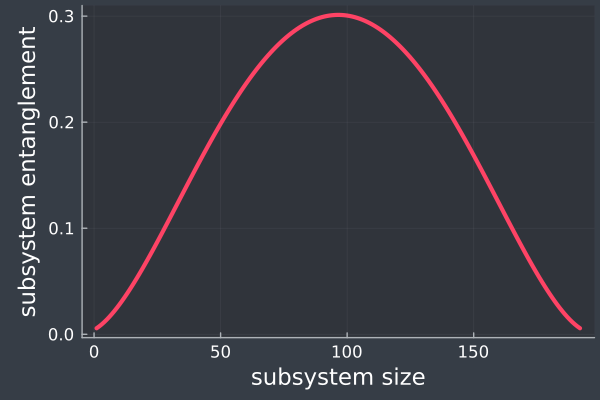

In [6]:
# define regions of space of increasing size
subsystemIndices = [collect(i-4:i+4) for i in 5:numSites-4]

# calculate entanglement entropy of these regions
SEE = [fermions.vnEntropy(eigvecs[1], indices) for indices in subsystemIndices]
Plots.plot(SEE, thickness_scaling=1.4, linewidth=3, legend=false,
        xlabel="subsystem size", ylabel="subsystem entanglement", margin=-1mm)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


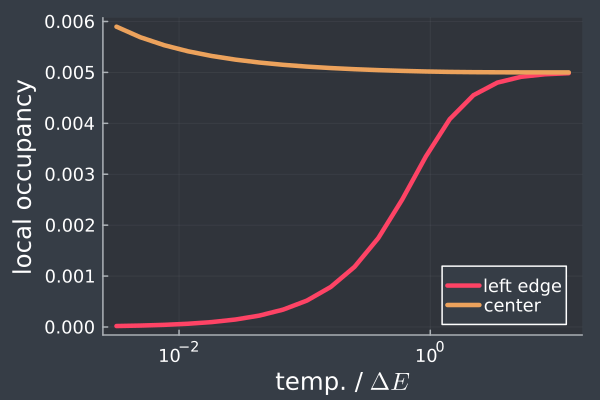

In [7]:
invTempRange = (10 .^ range(-0.5, stop=3.1, length=20)) ./ (maximum(eigvals) - minimum(eigvals))
leftOccOperator = [("n", [1], 1.0)]
leftOccAverage = [fermions.ThermalAverage(eigvecs, eigvals, leftOccOperator, beta) for beta in invTempRange]
centerOccOperator = [("n", [div(numSites, 2)], 1.0)]
centerOccAverage = [fermions.ThermalAverage(eigvecs, eigvals, centerOccOperator, beta) for beta in invTempRange]
Plots.plot(1 ./ invTempRange, [leftOccAverage, centerOccAverage];
    thickness_scaling=1.5, linewidth=3, 
    xaxis=:log10, xlabel="temp. / \$\\Delta E\$", ylabel="local occupancy", 
    labels=["left edge" "center"], leftmargin=-5mm, bottommargin=-3mm)

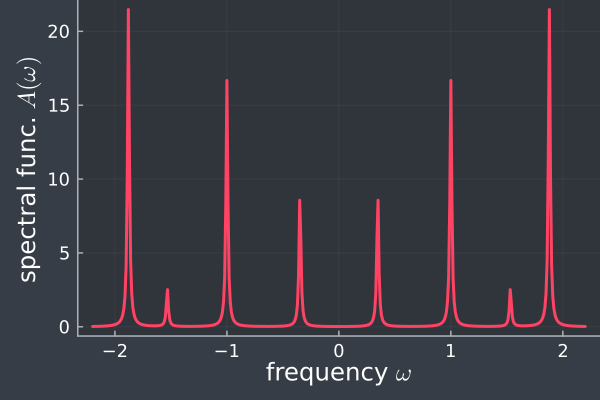

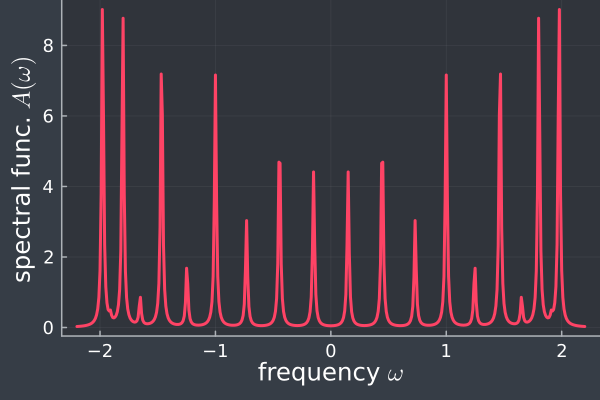

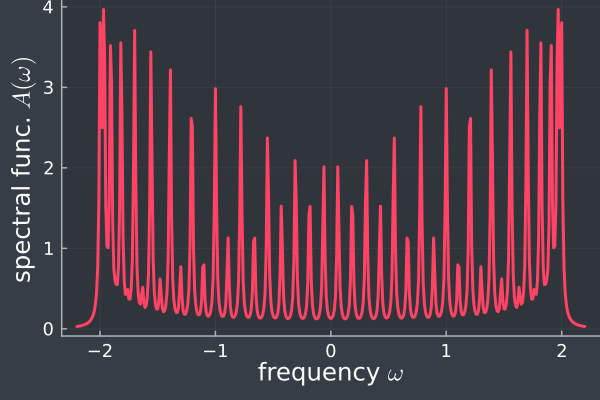

In [11]:
for numSites in [8, 20, 50]
    basis_N = fermions.BasisStates(numSites, 1)
    basis_Nm1 = fermions.BasisStates(numSites, 0)
    basis_Np1 = fermions.BasisStates(numSites, 2)
    tightBindHam = TightBindHamiltonian(numSites)
    eigvals_N, eigvecs_N = fermions.Spectrum(tightBindHam, basis_N)
    eigvals_Nm1, eigvecs_Nm1 = fermions.Spectrum(tightBindHam, basis_Nm1)
    eigvals_Np1, eigvecs_Np1 = fermions.Spectrum(tightBindHam, basis_Np1)
    freqArr = collect(range(-2.2, stop=2.2, step=0.01))
    probe = [("-", [div(numSites, 2)], 1.0)]
    probeDag = [("+", [div(numSites, 2)], 1.0)]
    specfunc = fermions.SpecFunc((eigvals_N[1], eigvecs_N[1]), [eigvals_Nm1; eigvals_Np1], 
        [eigvecs_Nm1; eigvecs_Np1], probe, probeDag, freqArr, 1e-2)
    p = Plots.plot(freqArr, specfunc, thickness_scaling=1.5, linewidth=2, legend=false, 
        xlabel="frequency \$\\omega\$", ylabel="spectral func. \$A(\\omega)\$", margin=-2mm)
    display(p)
end